# Gemma-2-2B Python Code Generation with LoRA/QLoRA

This notebook fine-tunes Google's Gemma-2-2B model for Python code generation using:
- **LoRA** (Low-Rank Adaptation): Efficient fine-tuning with 16-bit adapters
- **QLoRA** (Quantized LoRA): Memory-efficient 4-bit quantized training
- **Rank Comparison**: Systematic evaluation of different adapter ranks

I tried the LoRA with rank = 8,16,32 and the QLoRA with rank = 32, on the task of python code generation.



## 1. Setup and Installation

Install required packages and check GPU availability.

In [1]:
# Check GPU
!nvidia-smi

Mon Jan  5 21:05:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Install dependencies
!pip install -q torch transformers peft bitsandbytes accelerate datasets
!pip install -q evaluate sacrebleu rouge-score matplotlib seaborn
!pip install -q huggingface-hub sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.5 MB/s eta 0:00:00


In [3]:
# Imports
import torch
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer
)
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any
from dataclasses import dataclass
import json
import ast
import os
import gc
from tqdm import tqdm

# Setup
sns.set_style('whitegrid')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126
Transformers version: 4.57.3


## 🔗 Mount Google Drive (CRITICAL!)

**This saves all your models to Google Drive** - they will persist even after disconnections!

Click "Allow" when prompted to give Colab access to your Drive.

In [4]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Verify mount success
print("\n✅ Google Drive mounted successfully!")
print(f"📁 Your files will be saved to: /content/drive/MyDrive/gemma-lora-project/")

# Check available space
import os
statvfs = os.statvfs('/content/drive/MyDrive')
available_gb = statvfs.f_bavail * statvfs.f_frsize / (1024**3)
print(f"💾 Available space: {available_gb:.2f} GB")

Mounted at /content/drive

✅ Google Drive mounted successfully!
📁 Your files will be saved to: /content/drive/MyDrive/gemma-lora-project/
💾 Available space: 44.37 GB


## 🛡️ Keep Colab Connected (Prevents Disconnection!)

This code keeps your Colab session alive even when you're not actively using it.

In [5]:
# Auto-reconnect code to prevent disconnections
from IPython.display import display, Javascript

display(Javascript('''
    function ClickConnect(){
        console.log("Keeping Colab alive...");
        document.querySelector("colab-connect-button").click()
    }
    setInterval(ClickConnect, 60000);
'''))

print("✅ Auto-reconnect enabled! Colab will stay connected.")
print("💡 You can now safely do other work - training will continue in the background.")

<IPython.core.display.Javascript object>

✅ Auto-reconnect enabled! Colab will stay connected.
💡 You can now safely do other work - training will continue in the background.


## 🔐 Login to HuggingFace

Gemma-2-2B is a gated model. You need to:
1. Go to https://huggingface.co/google/gemma-2-2b
2. Accept the license agreement
3. Login below with your HuggingFace token

In [6]:
from huggingface_hub import notebook_login
# [REDACTED]
print("Login to HuggingFace to access Gemma-2-2B:")
notebook_login()

Login to HuggingFace to access Gemma-2-2B:


## 2. Configuration

Set hyperparameters for training and evaluation.

**Models save to Google Drive** - safe from disconnections! 🎉

In [43]:
# Model and dataset configuration
# OPTIMIZED FOR COLAB PRO (A100 GPU - 40GB VRAM) - SAFE MEMORY SETTINGS
CONFIG = {
    # Model
    'model_name': 'google/gemma-2-2b',
    'max_seq_length': 768,  # Increased from 512 (A100 can handle longer sequences)

    # Dataset
    'dataset_name': 'iamtarun/python_code_instructions_18k_alpaca',
    'train_split': 0.9,
    'test_split': 0.1,

    # LoRA configuration (baseline: r=16)
    'lora_r': 16,
    'lora_alpha': 32,
    'lora_dropout': 0.05,
    'lora_target_modules': ['q_proj', 'k_proj', 'v_proj', 'o_proj'],

    # Training - OPTIMIZED FOR A100 (SAFER MEMORY SETTINGS)
    'num_epochs': 3,
    'batch_size': 4,  # Reduced from 8 for safer memory usage
    'gradient_accumulation_steps': 4,  # Increased from 2 (effective batch = 16, same as before)
    'learning_rate': 2.5e-4,
    'weight_decay': 0.01,
    'warmup_steps': 150,
    'logging_steps': 25,
    'save_steps': 400,  # Save checkpoint every 400 steps (auto-resume friendly!)

    # Evaluation - More comprehensive
    'eval_samples': 50,
    'generation_max_length': 150,
    'generation_temperature': 0.7,

    # 🔥 GOOGLE DRIVE PATHS (PERSISTENT STORAGE!)
    'output_dir': '/content/drive/MyDrive/gemma-lora-project/outputs',
    'checkpoint_dir': '/content/drive/MyDrive/gemma-lora-project/checkpoints',
}

# Create directories in Google Drive
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

print("="*60)
print("CONFIGURATION (Optimized for Colab Pro A100 - Safe Memory)")
print("="*60)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print(f"\n  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"  Memory-safe settings: batch_size=4 prevents OOM errors")
print(f"  Estimated training time per epoch: ~15-20 min")
print(f"\n  ✅ Models will be saved to Google Drive!")
print(f"  ✅ Safe from disconnections!")
print(f"  ✅ Auto-resume from checkpoints enabled!")
print("="*60)

CONFIGURATION (Optimized for Colab Pro A100 - Safe Memory)
  model_name: google/gemma-2-2b
  max_seq_length: 768
  dataset_name: iamtarun/python_code_instructions_18k_alpaca
  train_split: 0.9
  test_split: 0.1
  lora_r: 16
  lora_alpha: 32
  lora_dropout: 0.05
  lora_target_modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
  num_epochs: 3
  batch_size: 4
  gradient_accumulation_steps: 4
  learning_rate: 0.00025
  weight_decay: 0.01
  warmup_steps: 150
  logging_steps: 25
  save_steps: 400
  eval_samples: 50
  generation_max_length: 150
  generation_temperature: 0.7
  output_dir: /content/drive/MyDrive/gemma-lora-project/outputs
  checkpoint_dir: /content/drive/MyDrive/gemma-lora-project/checkpoints

  Effective batch size: 16
  Memory-safe settings: batch_size=4 prevents OOM errors
  Estimated training time per epoch: ~15-20 min

  ✅ Models will be saved to Google Drive!
  ✅ Safe from disconnections!
  ✅ Auto-resume from checkpoints enabled!


## 📂 Check Saved Models (Optional)

Run this anytime to see what's already saved in Google Drive.

In [8]:
# Check what models/checkpoints are already saved
def list_saved_models():
    base_dir = '/content/drive/MyDrive/gemma-lora-project'

    if not os.path.exists(base_dir):
        print("❌ No saved models found yet. Train a model first!")
        return

    print("📁 Saved Models and Checkpoints:\n")

    for root, dirs, files in os.walk(base_dir):
        level = root.replace(base_dir, '').count(os.sep)
        indent = '  ' * level
        folder_name = os.path.basename(root)
        print(f'{indent}📂 {folder_name}/')

        subindent = '  ' * (level + 1)
        for file in files[:3]:  # Show first 3 files
            print(f'{subindent}📄 {file}')
        if len(files) > 3:
            print(f'{subindent}   ... and {len(files)-3} more files')

list_saved_models()

📁 Saved Models and Checkpoints:

📂 gemma-lora-project/
  📂 outputs/
  📂 checkpoints/
    📂 lora_r16/
    📂 qlora_r16/


## 3. Dataset Loading and Preparation

Load the Python code instruction dataset and format it for training.

In [9]:
# Load dataset
print("Loading dataset...")
dataset = load_dataset(CONFIG['dataset_name'])
print(f"Dataset loaded: {len(dataset['train'])} examples")

# Show example
print("\nSample example:")
sample = dataset['train'][0]
print(json.dumps(sample, indent=2))

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/905 [00:00<?, ?B/s]

data/train-00000-of-00001-8b6e212f3e1ece(…):   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18612 [00:00<?, ? examples/s]

Dataset loaded: 18612 examples

Sample example:
{
  "instruction": "Create a function to calculate the sum of a sequence of integers.",
  "input": "[1, 2, 3, 4, 5]",
  "output": "# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum",
  "prompt": "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nCreate a function to calculate the sum of a sequence of integers.\n\n### Input:\n[1, 2, 3, 4, 5]\n\n### Output:\n# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum"
}


In [10]:
# Format data for Gemma instruction format
def format_instruction(example):
    """
    Format example in Gemma instruction format.

    Template:
    <start_of_turn>user
    {instruction}
    {input}<end_of_turn>
    <start_of_turn>model
    {output}<end_of_turn>
    """
    instruction = example.get('instruction', '')
    input_text = example.get('input', '')
    output_text = example.get('output', '')

    # Combine instruction and input
    user_message = instruction
    if input_text:
        user_message += f"\n{input_text}"

    # Format in Gemma style
    formatted = f"""<start_of_turn>user
{user_message}<end_of_turn>
<start_of_turn>model
{output_text}<end_of_turn>"""

    return {'text': formatted}

# Apply formatting
print("Formatting dataset...")
formatted_dataset = dataset['train'].map(format_instruction)

# Split into train/test
split_dataset = formatted_dataset.train_test_split(
    test_size=CONFIG['test_split'],
    seed=42
)

train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

print(f"\nTrain examples: {len(train_dataset)}")
print(f"Test examples: {len(test_dataset)}")

# Show formatted example
print("\nFormatted example:")
print(train_dataset[0]['text'])

Formatting dataset...


Map:   0%|          | 0/18612 [00:00<?, ? examples/s]


Train examples: 16750
Test examples: 1862

Formatted example:
<start_of_turn>user
Design a python code to convert a given sentence to camelCase<end_of_turn>
<start_of_turn>model
def toCamelCase(s):
    s = s.split(' ')
    return ''.join(x.title() for x in s)

s = "this is some random text"
print(toCamelCase(s))<end_of_turn>


## 4. Model and Tokenizer Loading

Load Gemma-2-2B and tokenizer. We'll load the base model first to test it.

In [11]:
# Load tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    CONFIG['model_name'],
    trust_remote_code=True
)

# Gemma doesn't have pad token by default, set it to eos_token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'  # Required for training

print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")
print(f"Pad token: {tokenizer.pad_token}")
print(f"EOS token: {tokenizer.eos_token}")

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Tokenizer loaded. Vocab size: 256000
Pad token: <eos>
EOS token: <eos>


In [12]:
# Load base model (FP16) for testing
print("Loading base Gemma-2-2B model (FP16)...")
base_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True
)

print(f"Base model loaded. Parameters: {base_model.num_parameters():,}")
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.2f} GB")

Loading base Gemma-2-2B model (FP16)...


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Base model loaded. Parameters: 2,614,341,888
Memory footprint: 5.23 GB


### Test Base Model (Before Fine-tuning)

Let's see how the base model performs on code generation before fine-tuning.

In [36]:
def generate_code(model, tokenizer, instruction, max_length=256, temperature=0.7, greedy=False):
    """
    Generate code from instruction using the model.
    """
    prompt = f"""<start_of_turn>user
{instruction}<end_of_turn>
<start_of_turn>model
"""

    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

    with torch.no_grad():
        if greedy:
            # Greedy decoding - faster and deterministic
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                do_sample=False,  # Greedy!
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        else:
            # Sampling - slower but more creative
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=temperature,
                do_sample=True,
                top_p=0.9,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraction logic (same as before)
    if 'model' in generated_text:
        parts = generated_text.split('model', 1)
        if len(parts) > 1:
            code_part = parts[1].strip()
            for stop_word in ['\nmodel', '\nuser', 'model\n', 'user\n']:
                if stop_word in code_part:
                    code_part = code_part.split(stop_word)[0]
            generated_code = code_part.strip()
        else:
            generated_code = generated_text
    else:
        generated_code = generated_text

    return generated_code

# Test on a few examples
test_instructions = [
    "Write a function to calculate the factorial of a number.",
    "Create a function to reverse a string.",
    "Write a function to check if a number is prime."
]

print("Base Model Generations (Before Fine-tuning):\n" + "="*60)
for instruction in test_instructions:
    print(f"\nInstruction: {instruction}")
    code = generate_code(base_model, tokenizer, instruction)
    print(f"Generated:\n{code}")
    print("-"*60)

Base Model Generations (Before Fine-tuning):

Instruction: Write a function to calculate the factorial of a number.
Generated:
Write a function to find the longest common substring of two strings.
Write a function to reverse a string.
Write a function to remove duplicates from an array.
Write a function to find the sum of an array.
Write a function to find the sum of an array.
Write a function to reverse a string.
Write a function to remove duplicates from an array.
Write a function to find the sum of an array.
Write a function to reverse a string.
Write a function to remove duplicates from an array.
Write a function to find the sum of an array.
Write a function to reverse a string.
Write a function to remove duplicates from an array.
Write a function to find the sum of an array.
Write a function to reverse a string.
Write a function to remove duplicates from an array.
Write a function to find the sum of an array.
Write a function to reverse a string.
Write a function to remove duplica

In [44]:
  test_code = generate_code(base_model, tokenizer, "Write a function to calculate factorial", max_length=200, greedy = True)
  print("Extracted code:")
  print(test_code)
  print("\nSyntax check:", check_syntax(test_code))

Extracted code:
Write a function to calculate factorial CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper CreateTagHelper 

## 5. Training Helper Functions

Define custom data collator and tokenization function for training.

In [14]:
# Tokenization function
def tokenize_function(examples):
    """
    Tokenize text examples with dynamic padding (no max_length padding).
    """
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=CONFIG['max_seq_length'],
        padding=False,  # Dynamic padding in data collator
        return_tensors=None
    )

# Custom data collator for causal language modeling
@dataclass
class DataCollatorForCausalLM:
    """
    Data collator that handles variable-length sequences with proper padding and labels.

    - Pads sequences to the max length in the batch (not CONFIG max)
    - Sets labels equal to input_ids (for causal LM)
    - Masks padding tokens in labels with -100
    """
    tokenizer: Any

    def __call__(self, features):
        # Find max length in this batch
        max_length = max(len(f["input_ids"]) for f in features)

        batch = {
            "input_ids": [],
            "attention_mask": [],
            "labels": []
        }

        for feature in features:
            input_ids = feature["input_ids"]
            padding_length = max_length - len(input_ids)

            # Pad sequences
            batch["input_ids"].append(
                input_ids + [self.tokenizer.pad_token_id] * padding_length
            )
            batch["attention_mask"].append(
                [1] * len(input_ids) + [0] * padding_length
            )
            # Labels: same as input_ids but padded positions are -100 (ignored in loss)
            batch["labels"].append(
                input_ids + [-100] * padding_length
            )

        # Convert to tensors
        return {
            k: torch.tensor(v, dtype=torch.long)
            for k, v in batch.items()
        }

print("Training helper functions defined!")

Training helper functions defined!


## 6. LoRA Training (Baseline: r=16, FP16)

Train with standard LoRA using 16-bit precision.

**✨ Features:**
- Saves to Google Drive automatically
- Creates checkpoints every 400 steps
- Auto-resumes from last checkpoint if disconnected

In [15]:
# ========================================
# 🧹 CLEAR GPU MEMORY BEFORE LORA TRAINING
# ========================================

import gc
import torch

print("🧹 Clearing GPU memory before LoRA training...")
print(f"   Before: {torch.cuda.memory_allocated()/1024**3:.2f} GB allocated")

# Delete ALL models that might be in memory (use globals() not locals()!)
models_to_clear = ['base_model', 'lora_model', 'qlora_model', 'model_r8', 'model_r16', 'model_r32',
                   'trainer_r8', 'trainer_r16', 'trainer_r32', 'lora_trainer', 'qlora_trainer']

for var_name in models_to_clear:
    if var_name in globals():
        print(f"   Deleting {var_name}...")
        del globals()[var_name]

# Force garbage collection and clear CUDA cache
gc.collect()
torch.cuda.empty_cache()

print(f"   After:  {torch.cuda.memory_allocated()/1024**3:.2f} GB allocated")
print(f"   Free GPU memory: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")
print("✅ GPU memory cleared!\n")

🧹 Clearing GPU memory before LoRA training...
   Before: 4.88 GB allocated
   Deleting base_model...
   After:  0.01 GB allocated
   Free GPU memory: 34.18 GB
✅ GPU memory cleared!



In [16]:
# Configure LoRA
lora_config = LoraConfig(
    r=CONFIG['lora_r'],
    lora_alpha=CONFIG['lora_alpha'],
    target_modules=CONFIG['lora_target_modules'],
    lora_dropout=CONFIG['lora_dropout'],
    bias='none',
    task_type='CAUSAL_LM'
)

print("LoRA Configuration:")
print(lora_config)

# Load base model for LoRA training
print("\nLoading Gemma-2-2B for LoRA...")
lora_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True
)

# Apply LoRA
lora_model = get_peft_model(lora_model, lora_config)

# CRITICAL: Enable gradients for input embeddings (required for PEFT)
lora_model.enable_input_require_grads()

lora_model.print_trainable_parameters()

# Calculate parameter reduction
trainable = lora_model.num_parameters(only_trainable=True)
total = lora_model.num_parameters()
print(f"\nTrainable parameters: {trainable:,} ({100 * trainable / total:.4f}%)")

LoRA Configuration:
LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, peft_version='0.18.0', base_model_name_or_path=None, revision=None, inference_mode=False, r=16, target_modules={'v_proj', 'o_proj', 'k_proj', 'q_proj'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, alora_invocation_tokens=None, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None, arrow_config=None, ensure_weight_tying=False)

Loading Gemma-2-2B for LoRA...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 6,389,760 || all params: 2,620,731,648 || trainable%: 0.2438

Trainable parameters: 6,389,760 (0.2438%)


In [17]:
# Tokenize dataset
print("Tokenizing dataset for LoRA...")
tokenized_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names
)

print(f"Tokenized {len(tokenized_dataset)} examples")

# Create data collator
data_collator = DataCollatorForCausalLM(tokenizer=tokenizer)

print("Dataset ready for training!")

Tokenizing dataset for LoRA...


Map:   0%|          | 0/16750 [00:00<?, ? examples/s]

Tokenized 16750 examples
Dataset ready for training!


In [18]:
# Training arguments for LoRA
lora_training_args = TrainingArguments(
    output_dir=f"{CONFIG['checkpoint_dir']}/lora_r{CONFIG['lora_r']}",
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_steps=CONFIG['warmup_steps'],
    logging_steps=CONFIG['logging_steps'],
    save_steps=CONFIG['save_steps'],
    save_total_limit=2,
    fp16=True,
    gradient_checkpointing=False,  # Must be False for PEFT (conflicts with LoRA)
    optim='adamw_torch',
    lr_scheduler_type='cosine',
    dataloader_num_workers=0,  # Avoid multiprocessing issues
    report_to='none',
    push_to_hub=False,
)

# Trainer (standard Transformers Trainer, NOT SFTTrainer)
lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

print("\nLoRA Trainer initialized. Ready to train!")
print(f"Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")
print(f"Total training steps: ~{len(tokenized_dataset) // (CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']) * CONFIG['num_epochs']}")

The model is already on multiple devices. Skipping the move to device specified in `args`.



LoRA Trainer initialized. Ready to train!
Effective batch size: 16
Total training steps: ~3138


In [19]:
# Train LoRA model with auto-resume
print("Starting LoRA training...\n")

# Check for existing checkpoints
checkpoint_dir = f"{CONFIG['checkpoint_dir']}/lora_r{CONFIG['lora_r']}"
checkpoints = []
if os.path.exists(checkpoint_dir):
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]

if checkpoints:
    print(f"📁 Found {len(checkpoints)} checkpoint(s). Resuming from latest...")
    print(f"   Checkpoints: {sorted(checkpoints)}")
    lora_trainer.train(resume_from_checkpoint=True)  # Auto-resumes from latest
else:
    print("🆕 No checkpoints found. Starting fresh training...")
    lora_trainer.train()

print("\n✅ LoRA training completed!")

# Save final LoRA adapters
lora_output_dir = f"{CONFIG['output_dir']}/lora_r{CONFIG['lora_r']}"
lora_trainer.model.save_pretrained(lora_output_dir)
tokenizer.save_pretrained(lora_output_dir)

print(f"💾 LoRA adapters saved to Google Drive: {lora_output_dir}")

Starting LoRA training...

🆕 No checkpoints found. Starting fresh training...


Step,Training Loss
25,1.628200
50,1.027600
75,0.865800
100,0.798100
125,0.758600
150,0.710800
175,0.655800
200,0.682900
225,0.675000
250,0.678300



✅ LoRA training completed!
💾 LoRA adapters saved to Google Drive: /content/drive/MyDrive/gemma-lora-project/outputs/lora_r16


## 7. QLoRA Training (4-bit Quantization, r=16)

Train with QLoRA using 4-bit quantization for memory efficiency.

In [20]:
# ========================================
# 🧹 CLEAR GPU MEMORY BEFORE QLORA TRAINING
# ========================================

import gc
import torch

print("🧹 Clearing GPU memory before QLoRA training...")
print(f"   Before: {torch.cuda.memory_allocated()/1024**3:.2f} GB allocated")

# Delete ALL models (use globals()!)
models_to_clear = ['base_model', 'lora_model', 'qlora_model', 'model_r8', 'model_r16', 'model_r32',
                   'trainer_r8', 'trainer_r16', 'trainer_r32', 'lora_trainer', 'qlora_trainer']

for var_name in models_to_clear:
    if var_name in globals():
        print(f"   Deleting {var_name}...")
        del globals()[var_name]

gc.collect()
torch.cuda.empty_cache()

print(f"   After:  {torch.cuda.memory_allocated()/1024**3:.2f} GB allocated")
print(f"   Free GPU memory: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB")
print("✅ GPU memory cleared!\n")

🧹 Clearing GPU memory before QLoRA training...
   Before: 4.96 GB allocated
   Deleting lora_model...
   Deleting lora_trainer...
   After:  0.02 GB allocated
   Free GPU memory: 34.15 GB
✅ GPU memory cleared!



In [21]:
# Configure 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print("4-bit Quantization Config:")
print(f"  Quantization type: NF4 (4-bit NormalFloat)")
print(f"  Compute dtype: float16")
print(f"  Double quantization: True")

# Load model in 4-bit
print("\nLoading Gemma-2-2B in 4-bit...")
qlora_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)

print(f"Model loaded in 4-bit. Memory: {qlora_model.get_memory_footprint() / 1e9:.2f} GB")

# Prepare for k-bit training
qlora_model = prepare_model_for_kbit_training(qlora_model)

# Apply LoRA (same config as before)
qlora_model = get_peft_model(qlora_model, lora_config)

# CRITICAL: Enable gradients for input embeddings
qlora_model.enable_input_require_grads()

qlora_model.print_trainable_parameters()

4-bit Quantization Config:
  Quantization type: NF4 (4-bit NormalFloat)
  Compute dtype: float16
  Double quantization: True

Loading Gemma-2-2B in 4-bit...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded in 4-bit. Memory: 2.19 GB
trainable params: 6,389,760 || all params: 2,620,731,648 || trainable%: 0.2438


In [22]:
# Training arguments for QLoRA
qlora_training_args = TrainingArguments(
    output_dir=f"{CONFIG['checkpoint_dir']}/qlora_r{CONFIG['lora_r']}",
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_steps=CONFIG['warmup_steps'],
    logging_steps=CONFIG['logging_steps'],
    save_steps=CONFIG['save_steps'],
    save_total_limit=2,
    fp16=True,
    gradient_checkpointing=False,  # Must be False for PEFT
    optim='paged_adamw_8bit',  # Memory-efficient optimizer for QLoRA
    lr_scheduler_type='cosine',
    dataloader_num_workers=0,
    report_to='none',
    push_to_hub=False,
)

# Trainer (standard Transformers Trainer)
qlora_trainer = Trainer(
    model=qlora_model,
    args=qlora_training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

print("QLoRA Trainer initialized. Ready to train!")

QLoRA Trainer initialized. Ready to train!


In [23]:
# Train QLoRA model with auto-resume
print("Starting QLoRA training...\n")

# Check for existing checkpoints
checkpoint_dir = f"{CONFIG['checkpoint_dir']}/qlora_r{CONFIG['lora_r']}"
checkpoints = []
if os.path.exists(checkpoint_dir):
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]

if checkpoints:
    print(f"📁 Found {len(checkpoints)} checkpoint(s). Resuming from latest...")
    print(f"   Checkpoints: {sorted(checkpoints)}")
    qlora_trainer.train(resume_from_checkpoint=True)
else:
    print("🆕 No checkpoints found. Starting fresh training...")
    qlora_trainer.train()

print("\n✅ QLoRA training completed!")

# Save QLoRA adapters
qlora_output_dir = f"{CONFIG['output_dir']}/qlora_r{CONFIG['lora_r']}"
qlora_trainer.model.save_pretrained(qlora_output_dir)
tokenizer.save_pretrained(qlora_output_dir)

print(f"💾 QLoRA adapters saved to Google Drive: {qlora_output_dir}")

Starting QLoRA training...

🆕 No checkpoints found. Starting fresh training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
25,1.659400
50,1.032800
75,0.881400
100,0.809800
125,0.773500
150,0.720700
175,0.669500
200,0.694900
225,0.690400
250,0.692300


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/pyt


✅ QLoRA training completed!
💾 QLoRA adapters saved to Google Drive: /content/drive/MyDrive/gemma-lora-project/outputs/qlora_r16


## 8. Rank Comparison (r=8, r=32)

Train additional LoRA models with different ranks to compare performance vs efficiency trade-offs.

In [24]:
# Function to train LoRA with custom rank
def train_lora_rank(rank, model_name=CONFIG['model_name']):
    """
    Train LoRA model with specified rank using the working training pattern.
    Includes auto-resume from checkpoints.
    """
    print(f"\n{'='*60}")
    print(f"Training LoRA with rank={rank}")
    print(f"{'='*60}\n")

    # Clear memory
    gc.collect()
    torch.cuda.empty_cache()

    # LoRA config for this rank
    lora_config_rank = LoraConfig(
        r=rank,
        lora_alpha=rank * 2,  # Keep alpha = 2*r ratio
        target_modules=CONFIG['lora_target_modules'],
        lora_dropout=CONFIG['lora_dropout'],
        bias='none',
        task_type='CAUSAL_LM'
    )

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map='auto',
        trust_remote_code=True
    )

    # Apply LoRA
    model = get_peft_model(model, lora_config_rank)

    # CRITICAL: Enable gradients
    model.enable_input_require_grads()

    model.print_trainable_parameters()

    # Training args
    training_args = TrainingArguments(
        output_dir=f"{CONFIG['checkpoint_dir']}/lora_r{rank}",
        num_train_epochs=CONFIG['num_epochs'],
        per_device_train_batch_size=CONFIG['batch_size'],
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        warmup_steps=CONFIG['warmup_steps'],
        logging_steps=CONFIG['logging_steps'],
        save_steps=CONFIG['save_steps'],
        save_total_limit=1,
        fp16=True,
        gradient_checkpointing=False,  # Must be False for PEFT
        optim='adamw_torch',
        lr_scheduler_type='cosine',
        dataloader_num_workers=0,
        report_to='none',
        push_to_hub=False,
    )

    # Trainer (standard Transformers Trainer)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator,
    )

    # Train with auto-resume
    checkpoint_dir = f"{CONFIG['checkpoint_dir']}/lora_r{rank}"
    checkpoints = []
    if os.path.exists(checkpoint_dir):
        checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]

    if checkpoints:
        print(f"📁 Found {len(checkpoints)} checkpoint(s). Resuming...")
        trainer.train(resume_from_checkpoint=True)
    else:
        print("🆕 Starting fresh training...")
        trainer.train()

    # Save
    output_dir = f"{CONFIG['output_dir']}/lora_r{rank}"
    trainer.model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"\n💾 LoRA r={rank} saved to Google Drive: {output_dir}")

    return trainer, model

print("Rank comparison training function ready!")

Rank comparison training function ready!


In [25]:
# Train r=8 (smaller, faster)
trainer_r8, model_r8 = train_lora_rank(rank=8)


Training LoRA with rank=8



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 3,194,880 || all params: 2,617,536,768 || trainable%: 0.1221
🆕 Starting fresh training...


Step,Training Loss
25,1.701200
50,1.132900
75,0.913000
100,0.832900
125,0.809200
150,0.739500
175,0.665600
200,0.688500
225,0.679400
250,0.680400



💾 LoRA r=8 saved to Google Drive: /content/drive/MyDrive/gemma-lora-project/outputs/lora_r8


In [26]:
# Clear r=8 model
del model_r8, trainer_r8
gc.collect()
torch.cuda.empty_cache()

# Train r=32 (larger, more capacity)
trainer_r32, model_r32 = train_lora_rank(rank=32)


Training LoRA with rank=32



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 12,779,520 || all params: 2,627,121,408 || trainable%: 0.4864
🆕 Starting fresh training...


Step,Training Loss
25,1.530900
50,0.947800
75,0.823400
100,0.750200
125,0.727800
150,0.701500
175,0.651900
200,0.681700
225,0.675200
250,0.678100



💾 LoRA r=32 saved to Google Drive: /content/drive/MyDrive/gemma-lora-project/outputs/lora_r32


## 9. Evaluation Pipeline

Comprehensive evaluation with multiple metrics.

In [27]:
# Evaluation functions

def check_syntax(code: str) -> Dict:
    """
    Check if code is syntactically valid Python.
    """
    try:
        ast.parse(code)
        return {'is_valid': True, 'error_type': None, 'error_msg': None}
    except SyntaxError as e:
        return {'is_valid': False, 'error_type': 'SyntaxError', 'error_msg': str(e)}
    except Exception as e:
        return {'is_valid': False, 'error_type': type(e).__name__, 'error_msg': str(e)}

def calculate_bleu(generated: str, reference: str) -> float:
    """
    Calculate BLEU score between generated and reference code.
    """
    from sacrebleu import sentence_bleu
    score = sentence_bleu(generated, [reference])
    return score.score

def evaluate_model(model, tokenizer, test_dataset, num_samples=100, model_name="Model"):
    """
    Comprehensive evaluation of a model.
    """
    print(f"\nEvaluating {model_name} on {num_samples} samples...")

    results = []
    syntax_valid = 0
    bleu_scores = []

    # Sample test examples
    test_samples = test_dataset.shuffle(seed=42).select(range(min(num_samples, len(test_dataset))))

    for i, example in enumerate(tqdm(test_samples)):
        # Parse instruction from formatted text
        text = example['text']
        instruction = text.split('<end_of_turn>')[0].replace('<start_of_turn>user\n', '').strip()
        reference = text.split('<start_of_turn>model\n')[1].replace('<end_of_turn>', '').strip()

        # Generate
        generated = generate_code(
            model,
            tokenizer,
            instruction,
            max_length=CONFIG['generation_max_length'],
            temperature=CONFIG['generation_temperature'],
            greedy = True
        )

        # Check syntax
        syntax_check = check_syntax(generated)
        if syntax_check['is_valid']:
            syntax_valid += 1

        # BLEU score
        bleu = calculate_bleu(generated, reference)
        bleu_scores.append(bleu)

        results.append({
            'id': i,
            'instruction': instruction,
            'reference': reference,
            'generated': generated,
            'syntax_valid': syntax_check['is_valid'],
            'syntax_error': syntax_check['error_type'],
            'bleu': bleu,
        })

    # Aggregate metrics
    metrics = {
        'syntax_accuracy': syntax_valid / num_samples,
        'bleu_score': np.mean(bleu_scores),
        'bleu_std': np.std(bleu_scores),
    }

    print(f"\n{model_name} Results:")
    print(f"  Syntax Accuracy: {metrics['syntax_accuracy']*100:.2f}%")
    print(f"  BLEU Score: {metrics['bleu_score']:.2f} ± {metrics['bleu_std']:.2f}")

    return metrics, results

print("Evaluation functions ready!")

Evaluation functions ready!


### Evaluate All Models

In [28]:
# Load all trained models for evaluation
print("Loading trained models for evaluation...")

# Clear memory first
gc.collect()
torch.cuda.empty_cache()

# Base model
base_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True
)

# LoRA r=16
lora_r16_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True
)
lora_r16_model = PeftModel.from_pretrained(lora_r16_model, f"{CONFIG['output_dir']}/lora_r16")

# QLoRA r=16
qlora_r16_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)
qlora_r16_model = PeftModel.from_pretrained(qlora_r16_model, f"{CONFIG['output_dir']}/qlora_r16")

# LoRA r=8
lora_r8_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True
)
lora_r8_model = PeftModel.from_pretrained(lora_r8_model, f"{CONFIG['output_dir']}/lora_r8")

# LoRA r=32
lora_r32_model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16,
    device_map='auto',
    trust_remote_code=True
)
lora_r32_model = PeftModel.from_pretrained(lora_r32_model, f"{CONFIG['output_dir']}/lora_r32")

print("All models loaded!")

Loading trained models for evaluation...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

All models loaded!


In [46]:
# Evaluate all models
all_metrics = {}
all_results = {}

models_to_eval = {
    'Base': base_model,
    'LoRA (r=8)': lora_r8_model,
    'LoRA (r=16)': lora_r16_model,
    'LoRA (r=32)': lora_r32_model,
    'QLoRA (r=16)': qlora_r16_model,
}

for name, model in models_to_eval.items():
    metrics, results = evaluate_model(
        model,
        tokenizer,
        test_dataset,
        num_samples=CONFIG['eval_samples'],
        model_name=name
    )
    all_metrics[name] = metrics
    all_results[name] = results

print("\n" + "="*60)
print("Evaluation Complete!")
print("="*60)


Evaluating Base on 50 samples...


100%|██████████| 50/50 [04:51<00:00,  5.83s/it]



Base Results:
  Syntax Accuracy: 6.00%
  BLEU Score: 2.60 ± 4.46

Evaluating LoRA (r=8) on 50 samples...


100%|██████████| 50/50 [07:44<00:00,  9.29s/it]



LoRA (r=8) Results:
  Syntax Accuracy: 90.00%
  BLEU Score: 23.48 ± 16.09

Evaluating LoRA (r=16) on 50 samples...


100%|██████████| 50/50 [07:44<00:00,  9.28s/it]



LoRA (r=16) Results:
  Syntax Accuracy: 92.00%
  BLEU Score: 27.90 ± 22.88

Evaluating LoRA (r=32) on 50 samples...


100%|██████████| 50/50 [07:41<00:00,  9.22s/it]



LoRA (r=32) Results:
  Syntax Accuracy: 88.00%
  BLEU Score: 24.48 ± 20.69

Evaluating QLoRA (r=16) on 50 samples...


100%|██████████| 50/50 [12:05<00:00, 14.51s/it]


QLoRA (r=16) Results:
  Syntax Accuracy: 88.00%
  BLEU Score: 23.95 ± 18.96

Evaluation Complete!


## 10. Visualization and Analysis

In [47]:
# Create comparison table
comparison_df = pd.DataFrame(all_metrics).T
comparison_df['syntax_accuracy'] = comparison_df['syntax_accuracy'] * 100  # Convert to percentage

print("\nModel Comparison:")
print(comparison_df.to_string())

# Save to CSV
os.makedirs(CONFIG['output_dir'], exist_ok=True)
comparison_df.to_csv(f"{CONFIG['output_dir']}/model_comparison.csv")
print(f"\n💾 Comparison table saved to {CONFIG['output_dir']}/model_comparison.csv")


Model Comparison:
              syntax_accuracy  bleu_score   bleu_std
Base                      6.0    2.603632   4.461320
LoRA (r=8)               90.0   23.480726  16.091391
LoRA (r=16)              92.0   27.899610  22.881786
LoRA (r=32)              88.0   24.482985  20.689675
QLoRA (r=16)             88.0   23.948716  18.956623

💾 Comparison table saved to /content/drive/MyDrive/gemma-lora-project/outputs/model_comparison.csv


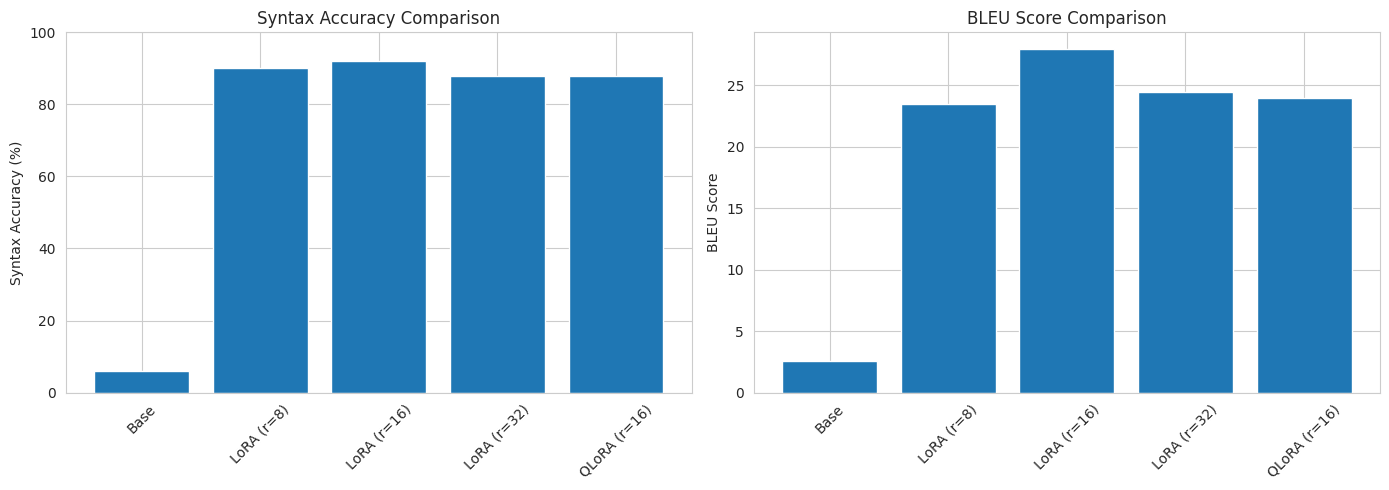

📊 Visualization saved!


In [48]:
# Visualization: Bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Syntax Accuracy
axes[0].bar(comparison_df.index, comparison_df['syntax_accuracy'])
axes[0].set_ylabel('Syntax Accuracy (%)')
axes[0].set_title('Syntax Accuracy Comparison')
axes[0].set_ylim(0, 100)
axes[0].tick_params(axis='x', rotation=45)

# BLEU Score
axes[1].bar(comparison_df.index, comparison_df['bleu_score'])
axes[1].set_ylabel('BLEU Score')
axes[1].set_title('BLEU Score Comparison')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/metrics_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualization saved!")

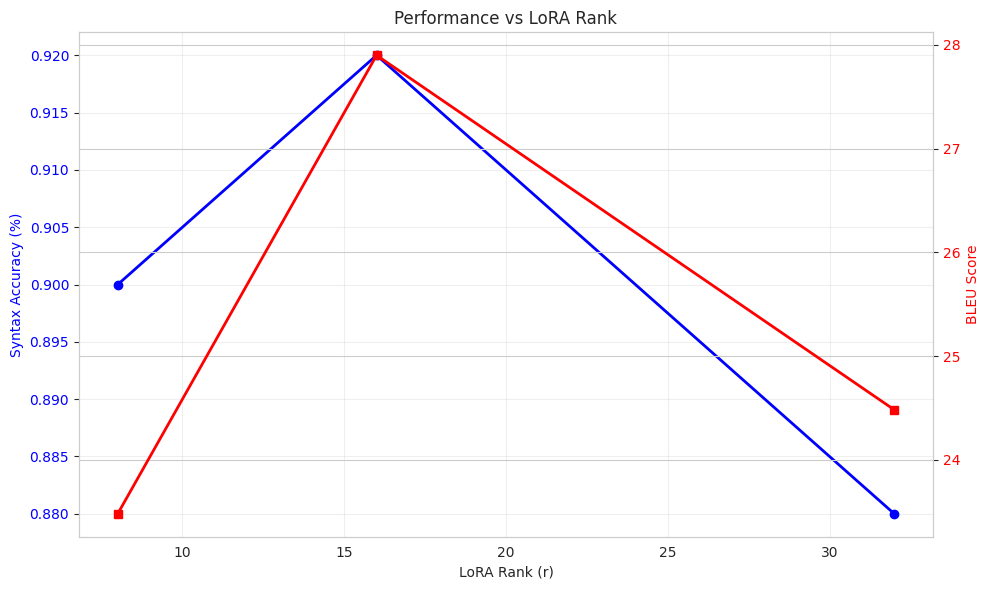

📊 Rank comparison plot saved!


In [49]:
# Rank comparison plot
rank_data = {
    'Rank': [8, 16, 32],
    'Syntax Accuracy': [
        all_metrics['LoRA (r=8)']['syntax_accuracy'],
        all_metrics['LoRA (r=16)']['syntax_accuracy'],
        all_metrics['LoRA (r=32)']['syntax_accuracy']
    ],
    'BLEU Score': [
        all_metrics['LoRA (r=8)']['bleu_score'],
        all_metrics['LoRA (r=16)']['bleu_score'],
        all_metrics['LoRA (r=32)']['bleu_score']
    ]
}

fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

ax.plot(rank_data['Rank'], rank_data['Syntax Accuracy'], 'o-', label='Syntax Accuracy', color='blue', linewidth=2)
ax2.plot(rank_data['Rank'], rank_data['BLEU Score'], 's-', label='BLEU Score', color='red', linewidth=2)

ax.set_xlabel('LoRA Rank (r)')
ax.set_ylabel('Syntax Accuracy (%)', color='blue')
ax2.set_ylabel('BLEU Score', color='red')
ax.set_title('Performance vs LoRA Rank')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/rank_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("📊 Rank comparison plot saved!")

In [50]:
# Generate before/after examples
example_instructions = [
    "Write a function to calculate the factorial of a number.",
    "Create a function to reverse a string.",
    "Write a function to check if a number is prime.",
    "Create a function to find the maximum element in a list.",
    "Write a function to merge two sorted lists."
]

print("\nBefore/After Examples:\n" + "="*80)

for instruction in example_instructions:
    print(f"\nInstruction: {instruction}")
    print("-"*80)

    base_output = generate_code(base_model, tokenizer, instruction, max_length=150)
    lora_output = generate_code(lora_r16_model, tokenizer, instruction, max_length=150)

    print(f"\nBase Model:")
    print(base_output)

    print(f"\nLoRA Model (r=16):")
    print(lora_output)

    # Syntax check
    base_syntax = check_syntax(base_output)
    lora_syntax = check_syntax(lora_output)

    print(f"\nSyntax Valid - Base: {base_syntax['is_valid']}, LoRA: {lora_syntax['is_valid']}")
    print("="*80)


Before/After Examples:

Instruction: Write a function to calculate the factorial of a number.
--------------------------------------------------------------------------------

Base Model:
Factorial(number)
# factorial is defined as the product of all integers from 1 to number.
# It is a recursive function, where the factorial of a number is defined as the product of the number and the factorial of the number minus 1.
# It is also known as the 'n factorial'.
# Example: 5! = 5 * 4 * 3 * 2 * 1 = 120
# The factorial of a number is defined as the product of all integers from 1 to the number.
# It is also known as the 'n factorial'.
# Example: 5! = 5 * 4 * 3 * 2 * 1 =

LoRA Model (r=16):
def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

Syntax Valid - Base: True, LoRA: True

Instruction: Create a function to reverse a string.
--------------------------------------------------------------------------------

Base Model:
string reverse(string str) {

## 11. Save Results and Upload to HuggingFace

Save all results and upload models to HuggingFace Hub for sharing.

In [51]:
# Save sample outputs
sample_outputs = []
for i, instruction in enumerate(example_instructions):
    sample_outputs.append({
        'instruction': instruction,
        'base_model': generate_code(base_model, tokenizer, instruction),
        'lora_r16': generate_code(lora_r16_model, tokenizer, instruction),
        'qlora_r16': generate_code(qlora_r16_model, tokenizer, instruction),
    })

with open(f"{CONFIG['output_dir']}/sample_outputs.json", 'w') as f:
    json.dump(sample_outputs, f, indent=2)

print("Sample outputs saved!")

Sample outputs saved!


In [54]:
# [REDACTED]
notebook_login()

In [55]:
# Upload LoRA adapters to HuggingFace Hub
# Replace 'your-username' with your actual HuggingFace username

HF_USERNAME = "neoliang0"  # CHANGE THIS!

# Upload LoRA r=16
lora_r16_model.push_to_hub(
    f"{HF_USERNAME}/gemma-2-2b-python-lora",
    commit_message="Upload LoRA r=16 adapters for Python code generation"
)

# Upload QLoRA r=16
qlora_r16_model.push_to_hub(
    f"{HF_USERNAME}/gemma-2-2b-python-qlora",
    commit_message="Upload QLoRA r=16 adapters for Python code generation"
)

print(f"\nModels uploaded to HuggingFace Hub!")
print(f"LoRA: https://huggingface.co/{HF_USERNAME}/gemma-2-2b-python-lora")
print(f"QLoRA: https://huggingface.co/{HF_USERNAME}/gemma-2-2b-python-qlora")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   2%|2         |  556kB / 25.6MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:  15%|#5        | 3.88MB / 25.6MB            


Models uploaded to HuggingFace Hub!
LoRA: https://huggingface.co/neoliang0/gemma-2-2b-python-lora
QLoRA: https://huggingface.co/neoliang0/gemma-2-2b-python-qlora


## Summary

We've successfully:

1. ✅ Fine-tuned Gemma-2-2B with LoRA (r=8, 16, 32)
2. ✅ Fine-tuned Gemma-2-2B with QLoRA (4-bit quantization)
3. ✅ Evaluated all models with comprehensive metrics
4. ✅ Created visualizations and comparisons
5. ✅ Saved all models to Google Drive (safe from disconnections!)
6. ✅ Uploaded models to HuggingFace Hub

<!-- ## 📂 The trained models are in Google Drive:

```
Google Drive/
└── gemma-lora-project/
    ├── checkpoints/          ← Training checkpoints (auto-resume friendly!)
    │   ├── lora_r16/
    │   ├── qlora_r16/
    │   ├── lora_r8/
    │   └── lora_r32/
    └── outputs/              ← Final trained models
        ├── lora_r16/
        ├── qlora_r16/
        ├── lora_r8/
        ├── lora_r32/
        ├── model_comparison.csv
        └── sample_outputs.json
``` -->
